<a href="https://colab.research.google.com/github/saikrishnachada/Traffic-Light-Classification-and-Detection/blob/master/TL_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install tensorflow-gpu==1.14
!pip install tensorflow==1.15

In [ ]:
!git clone --quiet https://github.com/tensorflow/models.git tf_models
  
!cp -r tf_models/research/object_detection object_detection/

!cp -r tf_models/research/slim slim/

!cp tfd/model_main.py object_detection/model_main.py

!rm -rf tfd

!rm -rf tf_models

!apt-get install -qq protobuf-compiler python-tk

!pip install -q Cython contextlib2 pillow lxml matplotlib PyDrive

!pip install -q pycocotools

!git clone https://github.com/cocodataset/cocoapi.git

%cd cocoapi/PythonAPI

!make

%cd /content

!cp -r cocoapi/PythonAPI/pycocotools pycocotools/

!rm -rf cocoapi

!protoc object_detection/protos/*.proto --python_out=.

%set_env PYTHONPATH=/content:/content/slim
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as vis_util

In [ ]:
!pip install tf_slim
!python object_detection/builders/model_builder_test.py

In [5]:
!git clone --quiet https://github.com/saikrishnachada/Traffic-Light-Classification-and-Detection.git Github_repo

In [6]:
import os
from zipfile import ZipFile
from shutil import copy
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# ID for frozen inference graph
frozen_file_id = '11gUJkJnwAqdFu5LlCnm3FPj727XdAM7R'

model_dir = 'model'

if not os.path.isdir(model_dir):
  os.makedirs(model_dir)

downloaded = drive.CreateFile({'id': frozen_file_id})
downloaded.GetContentFile(os.path.join(model_dir, 'frozen_inference_graph.pb'))

In [9]:
LABEL_PATH = 'Github_repo/data/label_map_simulator.pbtxt'
SIM_MODEL_PATH = 'model/frozen_inference_graph.pb'
SIM_TEST_IMAGE_PATH = 'Github_repo/data/test_images_simulator'
IMAGE_SIZE = (12, 8)

In [10]:
label_map = label_map_util.load_labelmap(LABEL_PATH)
categories = label_map_util.convert_label_map_to_categories(label_map, max_num_classes=4, use_display_name=True)
category_index = label_map_util.create_category_index(categories)
print(category_index)

{1: {'id': 1, 'name': 'Green'}, 2: {'id': 2, 'name': 'Red'}, 3: {'id': 3, 'name': 'Yellow'}}


In [11]:
def load_image_into_numpy_array(image):
  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (im_height, im_width, 3)).astype(np.uint8)

In [12]:
from glob import glob

In [13]:
def import_graph(model_path):
    detection_graph = tf.Graph()
    
    with detection_graph.as_default():
      od_graph_def = tf.GraphDef()
    
      with tf.gfile.GFile(model_path, 'rb') as fid:
        serialized_graph = fid.read()
        od_graph_def.ParseFromString(serialized_graph)
        tf.import_graph_def(od_graph_def, name='')
        
    return detection_graph
        
    
def load_test_images(directory):
    print(os.path.join(directory, '*.jpg'))
    image_paths = glob(os.path.join(directory, '*.jpg'))
    print("Length of test images:", len(image_paths))
    return image_paths

In [14]:
def predict(detection_graph, image_paths):
    with detection_graph.as_default():
        with tf.Session(graph=detection_graph) as sess:
            # Definite input and output Tensors for detection_graph
            image_tensor = detection_graph.get_tensor_by_name('image_tensor:0')

            # Each box represents a part of the image where a particular object was detected.
            detection_boxes = detection_graph.get_tensor_by_name('detection_boxes:0')

            # Each score represent how level of confidence for each of the objects.
            # Score is shown on the result image, together with the class label.
            detection_scores = detection_graph.get_tensor_by_name('detection_scores:0')
            detection_classes = detection_graph.get_tensor_by_name('detection_classes:0')
            num_detections = detection_graph.get_tensor_by_name('num_detections:0')
            for image_path in image_paths:
                image = Image.open(image_path)
                # the array based representation of the image will be used later in order to prepare the
                # result image with boxes and labels on it.
                image_np = load_image_into_numpy_array(image)
                # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
                image_np_expanded = np.expand_dims(image_np, axis=0)

                time0 = time.time()

                # Actual detection.
                (boxes, scores, classes, num) = sess.run(
                  [detection_boxes, detection_scores, detection_classes, num_detections],
                  feed_dict={image_tensor: image_np_expanded})

                time1 = time.time()

                boxes = np.squeeze(boxes)
                scores = np.squeeze(scores)
                classes = np.squeeze(classes).astype(np.int32)

                # Visualization of the results of a detection.
                vis_util.visualize_boxes_and_labels_on_image_array(
                    image_np, boxes, classes, scores,
                    category_index,
                    use_normalized_coordinates=True,
                    line_thickness=6)

                plt.figure(figsize=IMAGE_SIZE)
                plt.imshow(image_np)
                plt.show()

                min_score_thresh = .50
                for i in range(boxes.shape[0]):
                    if scores is None or scores[i] > min_score_thresh:
                        print(classes[i])
                        class_name = category_index[classes[i]]['name']
                        print('{}'.format(class_name), scores[i])

                        fx =  0.97428
                        fy =  1.73205
                        perceived_width_x = (boxes[i][3] - boxes[i][1]) * 800
                        perceived_width_y = (boxes[i][2] - boxes[i][0]) * 600

                        # ymin, xmin, ymax, xmax = box
                        # depth_prime = (width_real * focal) / perceived_width
                        perceived_depth_x = ((.1 * fx) / perceived_width_x)
                        perceived_depth_y = ((.3 * fy) / perceived_width_y )

                        estimated_distance = round((perceived_depth_x + perceived_depth_y) / 2)
                        print("Distance (metres)", estimated_distance)
                        print("Time in milliseconds", (time1 - time0) * 1000, "\n")

In [15]:
import numpy as np
import os
import sys
import tensorflow as tf
import time

from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt
from PIL import Image
%matplotlib inline

Github_repo/data/test_images_simulator/*.jpg
Length of test images: 12


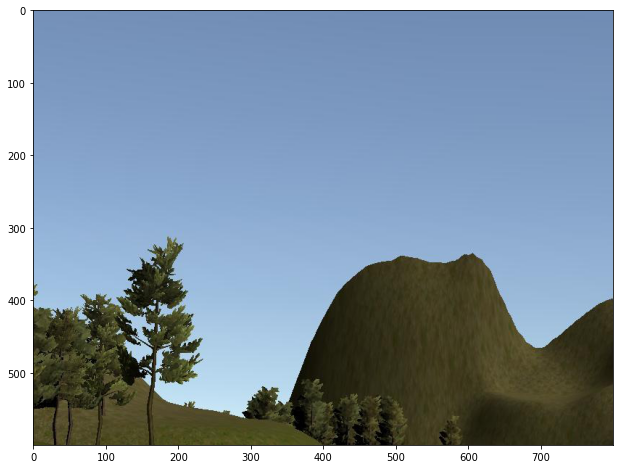

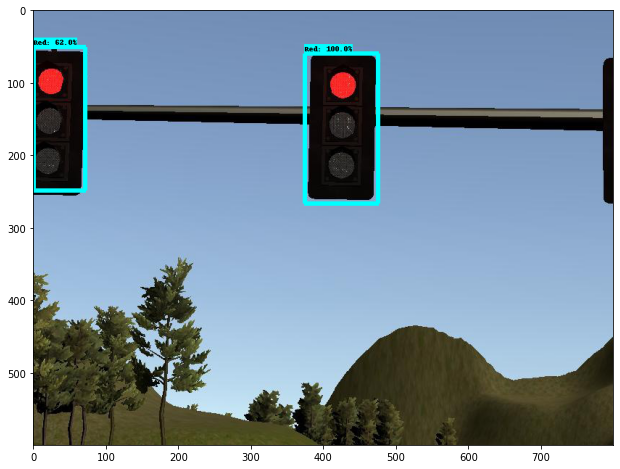

2
Red 0.9997493
Distance (metres) 0.0
Time in milliseconds 42.992591857910156 

2
Red 0.6234653
Distance (metres) 0.0
Time in milliseconds 42.992591857910156 



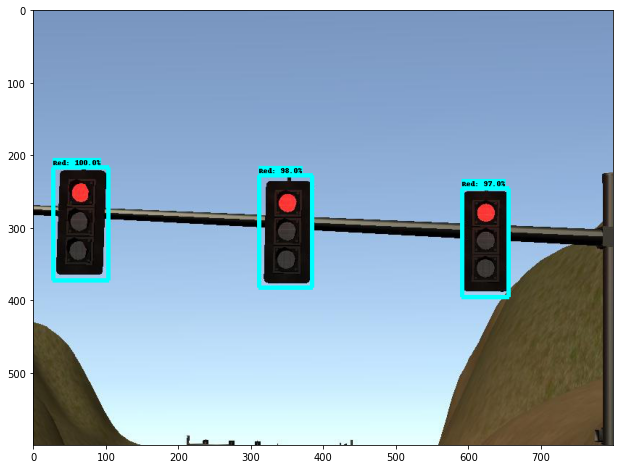

2
Red 0.9951966
Distance (metres) 0.0
Time in milliseconds 44.1136360168457 

2
Red 0.9846973
Distance (metres) 0.0
Time in milliseconds 44.1136360168457 

2
Red 0.9717176
Distance (metres) 0.0
Time in milliseconds 44.1136360168457 



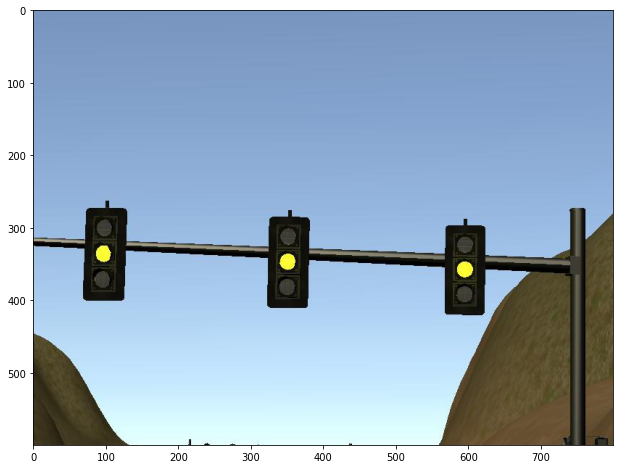

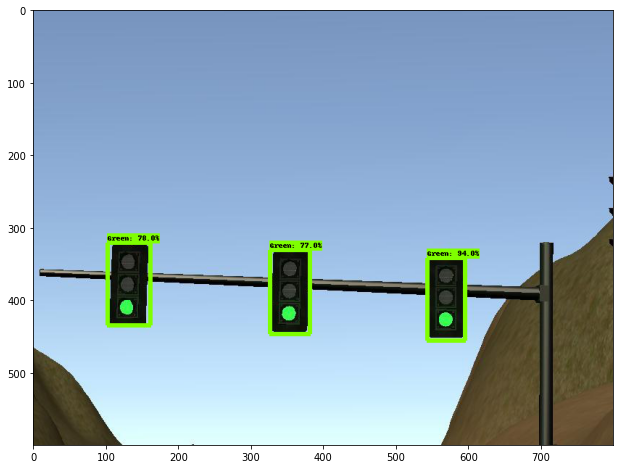

1
Green 0.93963504
Distance (metres) 0.0
Time in milliseconds 58.85791778564453 

1
Green 0.7830427
Distance (metres) 0.0
Time in milliseconds 58.85791778564453 

1
Green 0.7738962
Distance (metres) 0.0
Time in milliseconds 58.85791778564453 



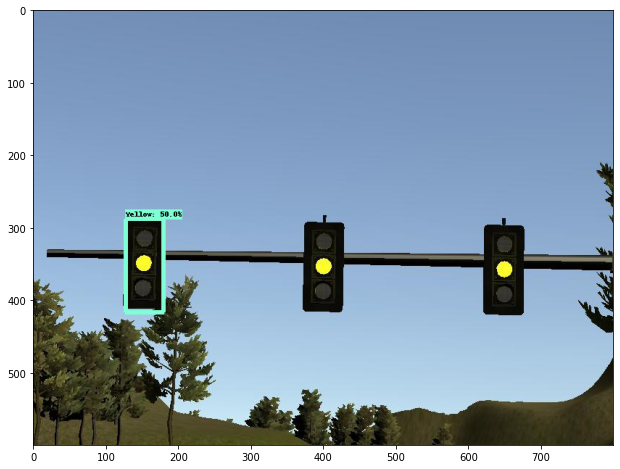

3
Yellow 0.5021584
Distance (metres) 0.0
Time in milliseconds 58.93588066101074 



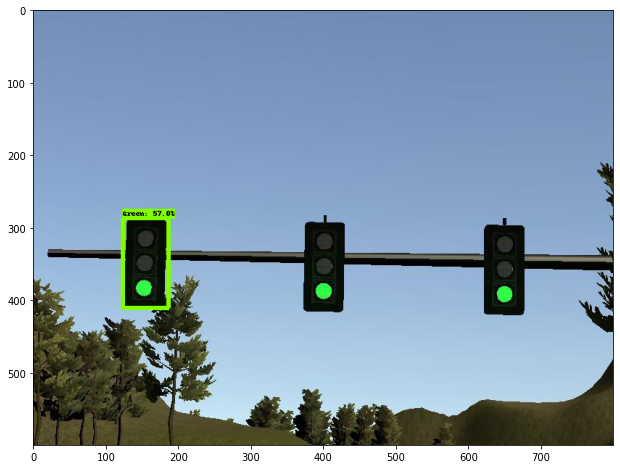

1
Green 0.57417923
Distance (metres) 0.0
Time in milliseconds 58.036088943481445 



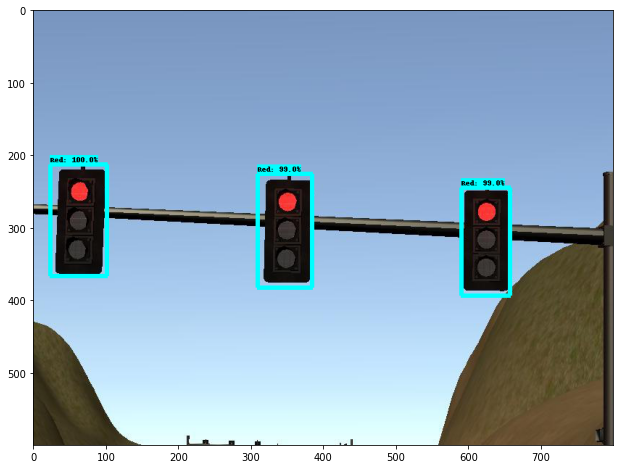

2
Red 0.9957737
Distance (metres) 0.0
Time in milliseconds 57.881832122802734 

2
Red 0.9869687
Distance (metres) 0.0
Time in milliseconds 57.881832122802734 

2
Red 0.98610485
Distance (metres) 0.0
Time in milliseconds 57.881832122802734 



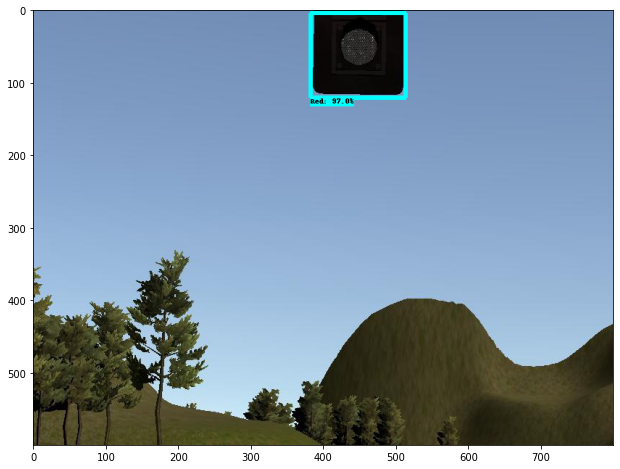

2
Red 0.9661128
Distance (metres) 0.0
Time in milliseconds 59.149742126464844 



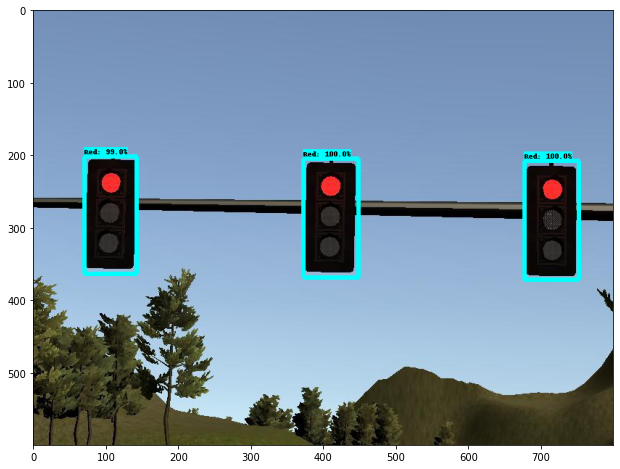

2
Red 0.9994708
Distance (metres) 0.0
Time in milliseconds 58.290719985961914 

2
Red 0.99934673
Distance (metres) 0.0
Time in milliseconds 58.290719985961914 

2
Red 0.99398524
Distance (metres) 0.0
Time in milliseconds 58.290719985961914 



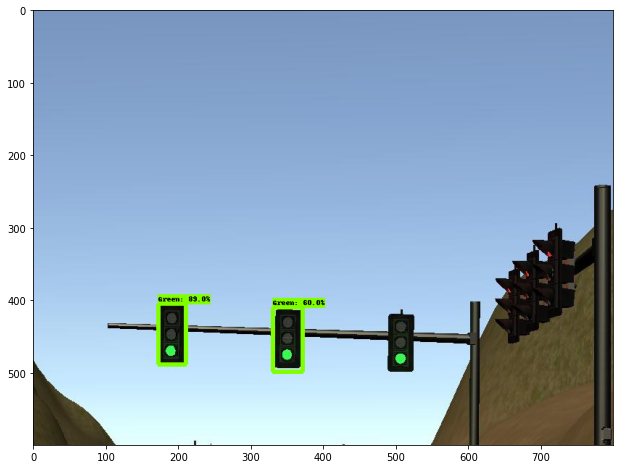

1
Green 0.89017
Distance (metres) 0.0
Time in milliseconds 58.460235595703125 

1
Green 0.5969417
Distance (metres) 0.0
Time in milliseconds 58.460235595703125 



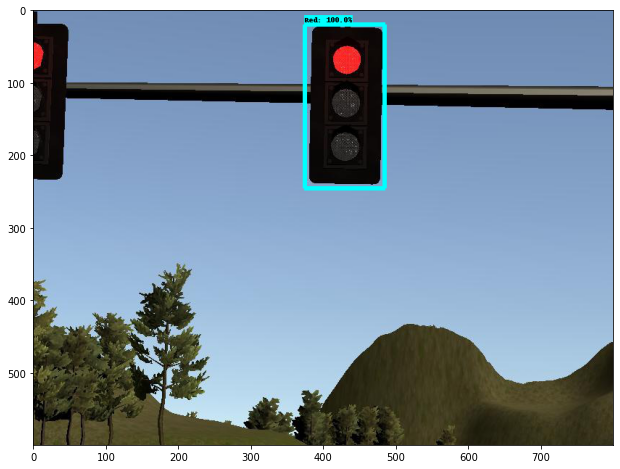

2
Red 0.99783933
Distance (metres) 0.0
Time in milliseconds 60.51230430603027 



In [16]:
detection_graph = import_graph(SIM_MODEL_PATH)
image_paths = load_test_images(SIM_TEST_IMAGE_PATH)
predict(detection_graph, image_paths)